
# Powerlifting Data Analysis


The aim of this notebook is:
- The data analysis of a subset of lifters (determined by the user).
- Predict how much kg can lift a lifter at bench and deadlift taking into account only the squat and bodyweight.
- Determine in which percentile is placed a lifter based on them lifts.



<h2>Table of content</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#import_data">Import Data from Openpowerlifting</a></li>
    <li><a href="#creating_subcategories">Creating subcategories</a></li>
    <li><a href="#predicting_liftings">Predicting liftings</a></li>
    <li><a href="#b_and_w">Box and Whiskers</a></li>
    <li><a href="#S_c_SVM">Sex classification using SVM</a></li>
</ol>

</div>
 
<hr>


<h3>Read me</h3>

- If you want to jump to another section and run it, **run section 1** before anything.
- To get the csv, [click here](https://openpowerlifting.gitlab.io/opl-csv/files/openipf-latest.zip) and change the name of the document to "openipf.csv".
- The cells that works have their output. Otherwise, they don't work.


<h2 id="import_data">1. Import Data from Openpowerlifting</h2>


<h4>Setup</h4>


In [1]:
### Setup ###

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import scipy
from scipy.stats import shapiro
from scipy.stats import iqr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import r2_score
import statistics



## Show unlimited rows and columns (just for debugging) ##

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [2]:
### Opening csv ###

path = 'openipf.csv'
df = pd.read_csv(path)
# Show the first 5 rows.
df.head()

### Categories and classes ###
# Bodyweight by sex
bw_F = (43, 47, 52, 57, 63, 69, 76, 84)
bw_M = (53, 59, 66, 74, 83, 93, 105, 120)
bw_Mx = (44, 48, 52, 56, 60, 67.5, 75, 82.5, 90, 100, 110, 125, 140)

# Age
age_c = {"Sub-Junior": 18, "Junior": 23, "Senior": 39, "Master I": 49, "Master II": 59, "Master III": 69, "Master IV": 70}

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (33,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
### Define functions ###

## Age category selection ##
# Building but it works #
def age_selection(df, age_c):
    while True:
        age_ = input("Write the age (integer) that was/is/will be reached in this year. Write -1 to include all ages: ")
        # Check if the input is a float.
        isInt = True
        try:
            # Convert age_ string to int.
            int(age_)
        except ValueError:
            isInt =  False
        if isInt:
            # Proceed to age category selection.
            break
        else:
            print("\nWrong age input. Please, try again.\n")

    age_ = int(age_)

    # Age selection when the value is higher than 0.
    if age_ > 0:
        if age_ <= age_c['Sub-Junior']:
            df = df.loc[df['BirthYearClass'] == '14-18']
        elif age_ <= age_c['Junior']:
            df = df.loc[df['BirthYearClass'] == '19-23']
        elif age_ <= age_c['Senior']:
            df = df.loc[df['BirthYearClass'] == '24-39']
        elif age_ <= age_c['Master I']:
            df = df.loc[df['BirthYearClass'] == '40-49']
        elif age_ <= age_c['Master II']:
            df = df.loc[df['BirthYearClass'] == '50-59']
        elif age_ <= age_c['Master III']:
            df = df.loc[df['BirthYearClass'] == '60-69']
        else:
            df = df.loc[df['BirthYearClass'] == '70-999']
    return df


## Equipment category selection ##
def equip_selection(df):
    while True:
        equip_ = input("Write equipment category ('Raw', 'Single-ply', 'Wraps' or 'All'): ").upper()
        if equip_ == 'RAW' or equip_ == 'SINGLE-PLY' or equip_ == 'WRAPS':
            break
        elif equip_ == 'ALL':
            break
        else:
            print("\nWrong equipment input. Please, try again.\n")
    return df.loc[df['Equipment'] == equip_]


## Bodyweight category selection ##
def bw_selection(df, sex_):
    while True:
        bw_ = input("Write the bodyweight within or without decimals. Write -1 to include all weights: ").upper()
        bw_ = bw_.replace(',','.')
        # Check if the input is a float.
        isFloat = True
        try:
            # Convert bw_ string to float.
            float(bw_)
        except ValueError:
            isFloat =  False
        if isFloat:
            # Proceed to bodyweight category selection.
            break
        else:
            print("\nWrong weight input. Please, try again.\n")

    ### At subjunior and junior categories, add a conditional 'and' that checks if the lifter is junior or subjunior. ###
    ### Age class selection is required before proceeding to bodyweight selection. ###

    bw_ = float(bw_)

    if bw_ > 0:

        # Female bodyweight categories
        if sex_ == 'F':
            # Subjunior and junior bodyweight category only.
            if bw_ <= bw_F[0]:
                df = df.loc[df['BodyweightKg'] <= bw_F[0]]
            elif bw_ <= bw_F[1]:
                df = df.loc[df['BodyweightKg'] <= bw_F[1]]
                df = df.loc[df['BodyweightKg'] > bw_F[0]]
            elif bw_ <= bw_F[2]:
                df = df.loc[df['BodyweightKg'] <= bw_F[2]]
                df = df.loc[df['BodyweightKg'] > bw_F[1]]
            elif bw_ <= bw_F[3]:
                df = df.loc[df['BodyweightKg'] <= bw_F[3]]
                df = df.loc[df['BodyweightKg'] > bw_F[2]]
            elif bw_ <= bw_F[4]:
                df = df.loc[df['BodyweightKg'] <= bw_F[4]]
                df = df.loc[df['BodyweightKg'] > bw_F[3]]
            elif bw_ <= bw_F[5]:
                df = df.loc[df['BodyweightKg'] <= bw_F[5]]
                df = df.loc[df['BodyweightKg'] > bw_F[4]]
            elif bw_ <= bw_F[6]:
                df = df.loc[df['BodyweightKg'] <= bw_F[6]]
                df = df.loc[df['BodyweightKg'] > bw_F[5]]
            elif bw_ <= bw_F[7]:
                df = df.loc[df['BodyweightKg'] <= bw_F[7]]
                df = df.loc[df['BodyweightKg'] > bw_F[6]]
            else:
                df = df.loc[df['BodyweightKg'] > bw_F[7]]

        # Male bodyweight categories
        elif sex_ == 'M':
            # Subjunior and junior bodyweight category only.
            if bw_ <= bw_M[0]:
                df = df.loc[df['BodyweightKg'] <= bw_M[0]]
            elif bw_ <= bw_M[1]:
                df = df.loc[df['BodyweightKg'] <= bw_M[1]]
                df = df.loc[df['BodyweightKg'] > bw_M[0]]
            elif bw_ <= bw_M[2]:
                df = df.loc[df['BodyweightKg'] <= bw_M[2]]
                df = df.loc[df['BodyweightKg'] > bw_M[1]]
            elif bw_ <= bw_M[3]:
                df = df.loc[df['BodyweightKg'] <= bw_M[3]]
                df = df.loc[df['BodyweightKg'] > bw_M[2]]
            elif bw_ <= bw_M[4]:
                df = df.loc[df['BodyweightKg'] <= bw_M[4]]
                df = df.loc[df['BodyweightKg'] > bw_M[3]]
            elif bw_ <= bw_M[5]:
                df = df.loc[df['BodyweightKg'] <= bw_M[5]]
                df = df.loc[df['BodyweightKg'] > bw_M[4]]
            elif bw_ <= bw_M[6]:
                df = df.loc[df['BodyweightKg'] <= bw_M[6]]
                df = df.loc[df['BodyweightKg'] > bw_M[5]]
            elif bw_ <= bw_M[7]:
                df = df.loc[df['BodyweightKg'] <= bw_M[7]]
                df = df.loc[df['BodyweightKg'] > bw_M[6]]
            else:
                df = df.loc[df['BodyweightKg'] > bw_M[7]]

        # Mx bodyweight categories (according to USA Powerlifting)
            # If all sexes are choosed, Mx criteria will be used.
        elif sex_ == 'MX' or sex_ == 'ALL':
            if bw_ <= bw_Mx[0]:
                df = df.loc[df['BodyweightKg'] <= bw_Mx[0]]
            elif bw_ <= bw_Mx[1]:
                df = df.loc[df['BodyweightKg'] <= bw_Mx[1]]
                df = df.loc[df['BodyweightKg'] > bw_Mx[0]]
            elif bw_ <= bw_Mx[2]:
                df = df.loc[df['BodyweightKg'] <= bw_Mx[2]]
                df = df.loc[df['BodyweightKg'] > bw_Mx[1]]
            elif bw_ <= bw_Mx[3]:
                df = df.loc[df['BodyweightKg'] <= bw_Mx[3]]
                df = df.loc[df['BodyweightKg'] > bw_Mx[2]]
            elif bw_ <= bw_Mx[4]:
                df = df.loc[df['BodyweightKg'] <= bw_Mx[4]]
                df = df.loc[df['BodyweightKg'] > bw_Mx[3]]
            elif bw_ <= bw_Mx[5]:
                df = df.loc[df['BodyweightKg'] <= bw_Mx[5]]
                df = df.loc[df['BodyweightKg'] > bw_Mx[4]]
            elif bw_ <= bw_Mx[6]:
                df = df.loc[df['BodyweightKg'] <= bw_Mx[6]]
                df = df.loc[df['BodyweightKg'] > bw_Mx[5]]
            elif bw_ <= bw_Mx[7]:
                df = df.loc[df['BodyweightKg'] <= bw_Mx[7]]
                df = df.loc[df['BodyweightKg'] > bw_Mx[6]]
            else:
                df = df.loc[df['BodyweightKg'] > bw_Mx[7]]
    return df


In [4]:
### Creating another dataframe ###

# df is kept as the original dataframe. df_c will be the modified dataframe.
df_c = df
df_c.head()

# Uppercase Equipment and Sex columns to make the input easier to the user.
df_c['Equipment'] = df_c['Equipment'].str.upper()
df_c['Sex'] = df_c['Sex'].str.upper()

<h2 id="creating_subcategories">2. Creating subcategories</h2>


<h4>Categories can be divided by Sex, Equipment, Age Class and Bodyweight.</h4>


In [ ]:
'''
FIXME: DO NOT RUN
Building
'''

### Age category selection previous discussion ###

# An other analysis within and without that values will be necessary if "Open" include outliners.

# It is noticed that 23.73 % of lifters will not be included using only the 'BirthYearClass' column because them have a nan value.
len(df_c.loc[df_c['BirthYearClass'].isna()]['Division'])/len(df_c['BirthYearClass'])*100

# Also, there are 577 unique values at the 'Division' column at the nan-BirthYearClass cases.
len(df_c.loc[df_c['BirthYearClass'].isna()]['Division'].unique())

# The list of 'Division' columns can be checked by the following instruction. We can check that there are categories that don't make any reference to the age.
df_c.loc[df_c['BirthYearClass'].isna()]['Division'].unique()

# In order to check how many divisions can be chosen without giving up significance.
# By including 95% lifters or more, it will be okay. By keeping more than 185,305 people.

# Dataframe only with the lifters that have a nan value at division.
df_c_test = df_c.loc[df_c['BirthYearClass'].isna()]
# List with unique values of 'Division' from the previous dataframe.
div_test = df_c_test['Division'].unique()

# List that will contain how many people are in each division.
len_div_test = []

for i in range(len(div_test)):
    len_div_test.append(len(df_c_test.loc[df_c_test['Division'] == div_test[i]]))
    
# Create an array that include the other lifters.
div_list = []

for i in range(0,20):
    div_list.append(div_test[np.min(np.where(len_div_test == np.min(max(len_div_test))))])
    len_div_test = np.delete(len_div_test, np.min(np.where(len_div_test == np.min(max(len_div_test)))), 0)

    
# 'Open' is the division with the maximum number of people: 134,182
    # However, the ages from these lifters are unknown. It could be possible guess that they are Senior.
# Open -> 24 - 39
# Junior II -> 19- 23
# FR-O -> 24 - 39
# Blind -> division of blind lifters.
# Master IV -> 70 - 999
# F-C-Open -> 24 - 39
# MR-Sj -> 14 - 18
# Under 15 -> Less than Subjunior
# 18-20 -> 19 - 23
# Master 40+ -> 40 - 49
# M-PL -> ?

len_div_test = np.array(len_div_test)
div_test[np.min(np.where(len_div_test == np.min(max(len_div_test))))]
div_list

# In order to know in which ages correspond each division (e.g. FR-O), check the ages at original dataframe.
# Wide range of ages: see distribution, choose mean or median.

In [5]:
### Create a subset by age, sex, equipment and bodyweight

df_c = age_selection(df_c, age_c)
while True:
    sex_ = input("Select Sex ('F' (Female), 'M' (Male), 'Mx' (Mixed) or 'All'): ").upper()
    if sex_ == 'F' or sex_ == 'M' or sex_ == 'MX':
        df_c = df_c.loc[df_c['Sex'] == sex_]
        break
    elif sex_ == 'ALL':
        break
    else:
        print("\nIncorrect input. Please, try again.\n")
df_c = equip_selection(df_c)
df_c = bw_selection(df_c, sex_)
# Drop from dataset competitors declassified by doping positive.
df_c = df_c.loc[df_c['Place'] != 'DD']

Write the age (integer) that was/is/will be reached in this year. Write -1 to include all ages: Hello

Wrong age input. Please, try again.

Write the age (integer) that was/is/will be reached in this year. Write -1 to include all ages: 24.5

Wrong age input. Please, try again.

Write the age (integer) that was/is/will be reached in this year. Write -1 to include all ages: 24
Select Sex ('F' (Female), 'M' (Male), 'Mx' (Mixed) or 'All'): 1

Incorrect input. Please, try again.

Select Sex ('F' (Female), 'M' (Male), 'Mx' (Mixed) or 'All'): f
Write equipment category ('Raw', 'Single-ply', 'Wraps' or 'All'): raw
Write the bodyweight within or without decimals. Write -1 to include all weights: 67,9




<h2 id="predicting_liftings">3. Predicting liftings</h2>


In [ ]:
### Show correlation between parameters
# df_c.corr()
    # Correlations between Best3SquatKg and BodyweightKg (0.613163), Best3SquatKg and Best3BenchKg (0.878804), Best3SquatKg and Best3DeadliftKg (0.898275), Best3SquatKg and TotalKg (0.974444), Best3SquatKg and Dots (0.805631), Best3SquatKg and Wilks (0.793271), Best3SquatKg and Glossbrenner (0.837061), Best3SquatKg and Goodlift (0.729958).
    # Correlations between Best3BenchKg and BodyweightKg (0.658468), Best3BenchKg and Best3DeadliftKg (0.854079), Best3Bench and GoodliftKg (0.611504).
    # Correlation between Best3DeadliftKg and BodyweightKg (0.635525).
    
# We will try to predict Best3BenchKg and Best3DeadliftKg using Best3SquatKg and BodyweightKg as predictors.

<h4>Bench press prediction.</h4>

In [6]:
# Define a new dataset for this case.

# df_c_b will be the part of the modified dataset to use for predict bench.
df_c_b = df_c.dropna(subset=['Best3SquatKg', 'Best3BenchKg'])
# Delete values below 0.
df_c_b = df_c_b.loc[df_c_b['Best3SquatKg'] > 0]
df_c_b = df_c_b.loc[df_c_b['Best3BenchKg'] > 0]
# Delete values above 1000 (unachievable).
df_c_b = df_c_b.loc[df_c_b['Best3SquatKg'] < 1000]
df_c_b = df_c_b.loc[df_c_b['Best3BenchKg'] < 1000]


0.6119340746235707


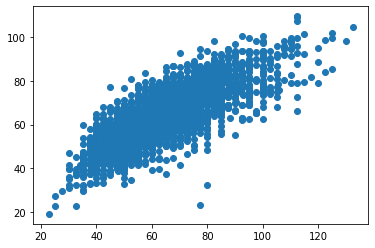

In [7]:
# Linear regression

lm = LinearRegression()
Z = df_c_b[['BodyweightKg', 'Best3SquatKg']]
y_1 = df_c_b['Best3BenchKg']
x_train, x_test, y_train, y_test = train_test_split(Z, y_1, test_size = 0.2, random_state = 0)

lm.fit(x_train,y_train)
lm.score(x_test,y_test)
y_hat = lm.predict(Z)

# Print score and scatterplot between predicted and real values of bench press
print(lm.score(x_test,y_test))
plt.scatter(y_1,y_hat)

0.614116078231904


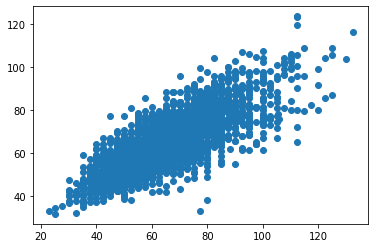

In [8]:
# Pipeline regression

Input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures(include_bias = False)), ('model', LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(x_train,y_train)
y_hat = pipe.predict(Z)

print(pipe.score(x_test, y_test))
plt.scatter(y_1,y_hat)

# Standard deviation from bench press (it will be used below)
std_dev_b = statistics.pstdev(y_1)

0.6119340710085966


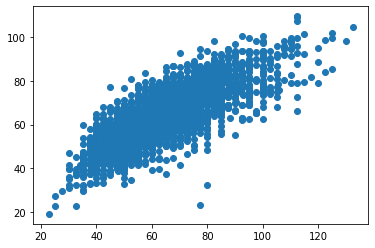

In [9]:
# Ridge regression

from sklearn.linear_model import Ridge

RidgeModel = Ridge(alpha = 0.1)
RidgeModel.fit(x_train, y_train)

RidgeModel.fit(x_train,y_train)
y_hat = RidgeModel.predict(Z)

print(RidgeModel.score(x_test, y_test))
plt.scatter(y_1,y_hat)

In [10]:
df_c.corr()
from sklearn.metrics import r2_score
regr = LinearRegression()

BS_np = np.array(df_c_b['Best3SquatKg'])
BB_np = np.array(df_c_b['Best3BenchKg'])
BS_np = [BS_np]
BB_np = [BB_np]
regr.fit(BS_np, BB_np)
bench_pred = regr.predict(BS_np)
# regr.score(BS_np, BB_np)
BB_np

[array([55. , 67.5, 60. , ..., 70. , 67.5, 72.5])]

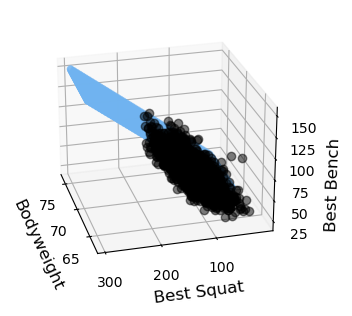

In [11]:
# Print 3D scatterplot: bodyweight, squat and bench
### Building (but it can be run) ###

import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('default')
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131, projection='3d')

x_pred = np.linspace(69, 76)   # range of bodyweight (these values should be variables)
y_pred = np.linspace(25, 293)  # range of best squat
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
model = lm.fit(Z, y_1)
predicted = model.predict(model_viz)

ax.plot(Z['BodyweightKg'], Z['Best3SquatKg'], y_1, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
ax.set_xlabel('Bodyweight', fontsize=12)
ax.set_ylabel('Best Squat', fontsize=12)
ax.set_zlabel('Best Bench', fontsize=12)
ax.locator_params(nbins=4, axis='x')
ax.locator_params(nbins=5, axis='x')

# Change the point of view
ax.view_init(elev=25, azim=165)

In [12]:
### Predicting bench press using the pipeline model ###
# R^2 = 0.5892572315922986
    # Female, Raw, Senior and -76 kg.

# First input: BodyweightKg
# Second input: Best3SquatKg

while True:
    bw_1 = input("Write a bodyweight: ")
    bw_1 = bw_1.replace(',','.')
    # Check if the input is a float.
    isFloat = True
    try:
        # Convert bw_ string to float.
        float(bw_1)
    except ValueError:
        isFloat =  False
    if isFloat:
        # Proceed to bodyweight category selection.
        break
    else:
        print("\nWrong weight input. Please, try again.\n")
bw_1 = float(bw_1)

while True:
    sq_1 = input("Write an squat attempt: ")
    sq_1 = sq_1.replace(',','.')
    # Check if the input is a float.
    isFloat = True
    try:
        # Convert bw_ string to float.
        float(sq_1)
    except ValueError:
        isFloat =  False
    if isFloat:
        # Proceed to bodyweight category selection.
        break
    else:
        print("\nWrong weight input. Please, try again.\n")
sq_1 = float(sq_1)

# The standard deviation (std_dev_b) is used to make an approach.
print("The predicted bench is: " + str(round(float(pipe.predict(np.array([[bw_1, sq_1]]))), 2)) + " ± " + str(round(std_dev_b/2, 2)) + " Kg.")

Write a bodyweight: 67,9
Write an squat attempt: 135
The predicted bench is: 74.55 ± 7.5 Kg.


<h4>Deadlift prediction (building).</h4>
It has to work like the bench prediction.

In [13]:
# df_c_d will be the part of the modified dataset to use for predict deadlift.
df_c_d = df_c.dropna(subset=['Best3SquatKg', 'Best3DeadliftKg'])
# Delete values below 0.
df_c_d = df_c_b.loc[df_c_b['Best3SquatKg'] > 0]
df_c_d = df_c_b.loc[df_c_b['Best3DeadliftKg'] > 0]


0.6949762839234368


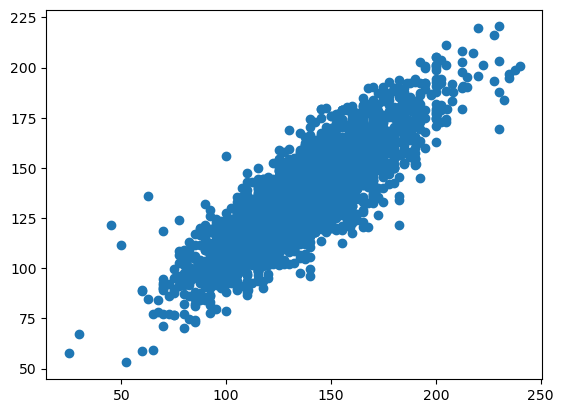

In [14]:
# Linear regression

lm = LinearRegression()
Z = df_c_d[['BodyweightKg', 'Best3SquatKg']]
y_1 = df_c_d['Best3DeadliftKg']
x_train, x_test, y_train, y_test = train_test_split(Z, y_1, test_size = 0.2, random_state = 0)

lm.fit(x_train,y_train)
lm.score(x_test,y_test)
y_hat = lm.predict(Z)

# Print score and scatterplot between predicted and real values of bench press
print(lm.score(x_test,y_test))
plt.scatter(y_1,y_hat)

0.6939112553538556


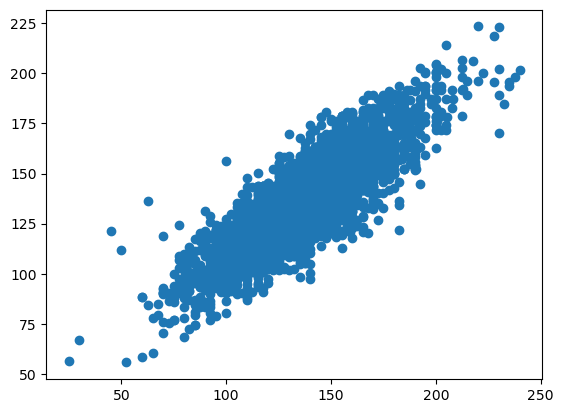

In [15]:
# Pipeline regression

Input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures(include_bias = False)), ('model', LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(x_train,y_train)
y_hat = pipe.predict(Z)

print(pipe.score(x_test, y_test))
plt.scatter(y_1,y_hat)

0.6949763368737218


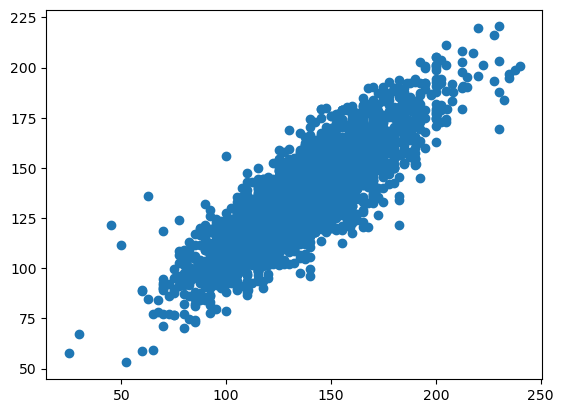

In [16]:
# Ridge regression

from sklearn.linear_model import Ridge

RidgeModel = Ridge(alpha = 0.1)
RidgeModel.fit(x_train, y_train)

y_hat = RidgeModel.predict(Z)

print(RidgeModel.score(x_test, y_test))
plt.scatter(y_1,y_hat)

<h2 id="b_and_w">4. Box and whiskers</h2>


We will create different data_frames.

**Maybe, it will be necessary redo this section**


In [47]:
# Reset df_c
df_c = df
df_c['Equipment'] = df_c['Equipment'].str.upper()
df_c['Sex'] = df_c['Sex'].str.upper()
age_selection(df_c, age_c)            
equip_selection(df_c)
bw_selection(df_c, 'F')
# Drop from dataset competitors declassified by doping positive.
df_c = df_c.loc[df_c['Place'] != 'DD']

df_Kg = df_c.loc[:,['Name', 'Sex', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']]
# df.columns
# df.axes


Write the age (integer) that was/is/will be reached in this year. Write -1 to include all ages: 24
Write equipment category ('Raw', 'Single-ply', 'Wraps' or 'All'): Raw
Write the bodyweight within or without decimals. Write -1 to include all weights: 68


In [48]:
### FIXME: RUN TO IMPORT math
# Truncate numbers to work with box and whiskers

import math
# math.trunc(df_Kg[['BodyweightKg']])
# math.trunc(df_Kg['BodyweightKg']).at(0,0)
# df_Kg.at(0,'BodyweightKg')
# [0:lenght(df_Kg[['BodyweightKg']]):1]

In [49]:
# Different dataframes for each lifting. Unique lifters.
    # The difference is the ausence of some NaN values.

df_Squat = df_Kg[['Name', 'Sex', 'BodyweightKg', 'Best3SquatKg']].set_index(df_Kg['Name'])
df_Squat = df_Squat[['Sex', 'Best3SquatKg']].dropna()
df_Squat = df_Squat.max(level='Name')
df_Squat = df_Squat.loc[df_Squat['Best3SquatKg'] > 0]

df_Bench = df_Kg[['Name', 'Sex', 'BodyweightKg', 'Best3BenchKg']].set_index(df_Kg['Name'])
df_Bench = df_Bench[['Sex', 'Best3BenchKg']].dropna()
df_Bench = df_Bench.max(level='Name')
df_Bench = df_Bench.loc[df_Bench['Best3BenchKg'] > 0]

df_Deadlift = df_Kg[['Name', 'Sex', 'BodyweightKg', 'Best3DeadliftKg']].set_index(df_Kg['Name'])
df_Deadlift = df_Deadlift[['Sex', 'Best3DeadliftKg']].dropna()
df_Deadlift = df_Deadlift.max(level='Name')
df_Deadlift = df_Deadlift.loc[df_Deadlift['Best3DeadliftKg'] > 0]

C:\Users\amaia\AppData\Local\Temp/ipykernel_4320/515328168.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_Squat = df_Squat.max(level='Name')
C:\Users\amaia\AppData\Local\Temp/ipykernel_4320/515328168.py:11: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_Bench = df_Bench.max(level='Name')
C:\Users\amaia\AppData\Local\Temp/ipykernel_4320/515328168.py:16: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_Deadlift = df_Deadlift.max(level='Name')


232.5
130.0
Statistics=0.987, p=0.000
Sample does not look Gaussian (reject H0)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


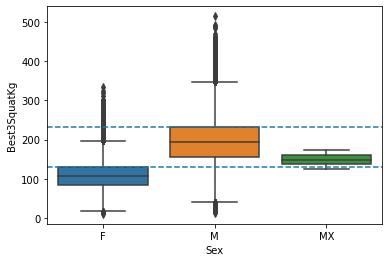

In [50]:
### Building ###
### Percentile display ###

perc = 0.75
# ax1 = sns.boxplot(x = "Best3SquatKg", data=df_Squat)

# In case of selecting all Sex categories 
ax1 = sns.boxplot(x = "Sex", y = "Best3SquatKg", data=df_Squat)
# df_c_squat_M = df_Squat.loc[df_Squat['Sex'] == 'M']
df_c_squat_F = df_Squat.loc[df_Squat['Sex'] == 'F']
# Percentile to show
print(float(df_c_squat_M.quantile(perc)))
print(float(df_c_squat_F.quantile(perc)))
ax1.axhline(float(df_c_squat_M.quantile(perc)), ls='--')
ax1.axhline(float(df_c_squat_F.quantile(perc)), ls='--')



# Normality test
scipy.stats.normaltest(df_Squat['Best3SquatKg'])

stat, p = shapiro(df_Squat['Best3SquatKg'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

160.0
72.5
Statistics=0.927, p=0.000
Sample does not look Gaussian (reject H0)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


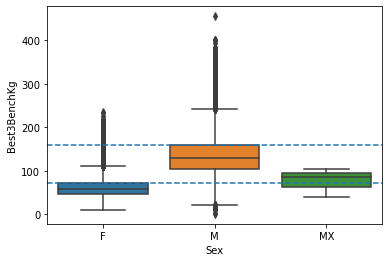

In [13]:
# df_c_bench = df_c.loc[df_c['Best3BenchKg'] > 0]
df_c_bench_M = df_Bench.loc[df_Bench['Sex'] == 'M']
df_c_bench_F = df_Bench.loc[df_Bench['Sex'] == 'F']
ax2 = sns.boxplot(x = "Sex", y = "Best3BenchKg", data=df_Bench)

print(float(df_c_bench_M.quantile(perc)))
print(float(df_c_bench_F.quantile(perc)))

ax2.axhline(float(df_c_bench_M.quantile(perc)), ls='--')
ax2.axhline(float(df_c_bench_F.quantile(perc)), ls='--')

# ax2 = sns.boxplot(x="Best3BenchKg", data=df_Bench, palette="Set2")
# ax2.axvline(80, ls='--')

# Normality test
scipy.stats.normaltest(df_c_bench_F['Best3BenchKg'])

stat, p = shapiro(df_c_bench_F['Best3BenchKg'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

250.0
145.0
Statistics=0.996, p=0.000
Sample does not look Gaussian (reject H0)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


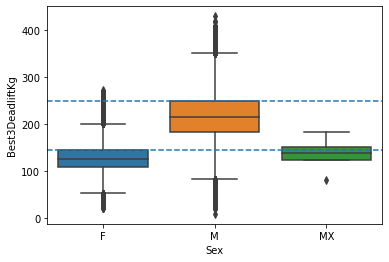

In [14]:
# ax3 = sns.boxplot(x="Best3DeadliftKg", data=df_Bench, palette="Set2")
# ax3.axvline(160, ls='--')

# df_c_deadlift = df_c.loc[df_c['Best3DeadliftKg'] > 0]
df_c_deadlift_M = df_Deadlift.loc[df_Deadlift['Sex'] == 'M']
df_c_deadlift_F = df_Deadlift.loc[df_Deadlift['Sex'] == 'F']
ax3 = sns.boxplot(x = "Sex", y = "Best3DeadliftKg", data=df_Deadlift)

print(float(df_c_deadlift_M.quantile(perc)))
print(float(df_c_deadlift_F.quantile(perc)))
# print(iqr(df_c_deadlift_M))

ax3.axhline(float(df_c_deadlift_M.quantile(perc)), ls='--')
ax3.axhline(float(df_c_deadlift_F.quantile(perc)), ls='--')

# Normality test
scipy.stats.normaltest(df_c_deadlift_F['Best3DeadliftKg'])

stat, p = shapiro(df_c_deadlift_F['Best3DeadliftKg'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

In [51]:
squat_F_norm = np.random.normal(statistics.mean(df_c_squat_F['Best3SquatKg']), statistics.stdev(df_c_squat_F['Best3SquatKg']), 2000)



Statistics=0.981, p=0.000
Sample does not look Gaussian (reject H0)


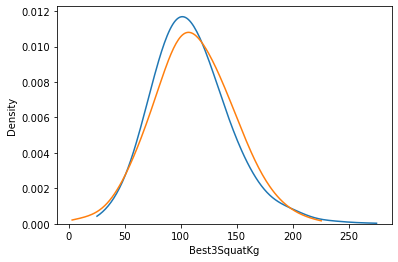

In [52]:
### Building ###

import scipy
from scipy.stats import shapiro

# Density distribution of each lifting.

# sns.distplot(df_c_deadlift_F['Best3DeadliftKg'], hist=False)
    # 'Displot' is a deprecated function and will be removed in a future version.

sns.kdeplot(data=df_c_squat_F.sample(n=2000), x="Best3SquatKg", bw_adjust = 1.7, cut = 0, palette="crest")
sns.kdeplot(x=squat_F_norm, bw_adjust = 1.7, cut = 0, palette="crest")
# sns.kdeplot(data=df_c_bench_F, x="Best3BenchKg", bw_adjust = 1.7, cut = 0, palette="crest")
# sns.kdeplot(data=df_c_deadlift_F, x="Best3DeadliftKg", bw_adjust = 1.7, cut = 0, palette="crest")

# Normality test
scipy.stats.normaltest(df_c_squat_F['Best3SquatKg'].sample(n=2000))

stat, p = shapiro(df_c_squat_F['Best3SquatKg'].sample(n=2000))
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')


<h2 id="S_c_SVM">5. Sex classification using SVM </h2>


In this case, taking into account the lifts, we will tag the lifts if them are tipically from a female or male lifter.
Only liftings will be used to simplify the analysis.

**Futher work: remove columns from X (for example, it could be interesting remove squat or deadlift because they are high correlated)**
**Also, it could be interesting include the BodyweightKg column**


In [58]:
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import cross_val_score

# df_c will be reused and reset.
df_c = df
df_c['Equipment'] = df_c['Equipment'].str.upper()
df_c['Sex'] = df_c['Sex'].str.upper()
# Drop from dataset competitors declassified by doping positive.
df_c = df_c.loc[df_c['Place'] != 'DD']

In [59]:
### Age, Bodyweight and equipment category selection ###

age_selection(df_c, age_c)            
equip_selection(df_c)
bw_selection(df_c, 'All')

# Drop from dataset competitors declassified by doping positive.
df_c = df_c.loc[df_c['Place'] != 'DD']

# Just keep lifts and sex columns
df_c = df_c.loc[:,['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'Sex']]
df_c = df_c.dropna()

# Select only lifters with the Sex tagged as M or F.
df_c = df_c[df_c.Sex != 'Mx']

Write the age (integer) that was/is/will be reached in this year. Write -1 to include all ages: 24
Write equipment category ('Raw', 'Single-ply', 'Wraps' or 'All'): raw
Write the bodyweight within or without decimals. Write -1 to include all weights: 68


In [60]:
# Drop random values for a fast training.
try:
    df_c = df_c.sample(n=20000)
except:
    pass
    
# Define X and y for train the dataset
X = np.asarray(df_c.loc[:,['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']])

# Male sex will be tagged as 2 and female as 4.
y = df_c.replace({'M': 2, 'F': 4})
y = np.asarray(y.loc[:,['Sex']]).flatten()

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

# Predict new values
yhat = clf.predict(X_test)

Train set: (16000, 4) (16000,)
Test set: (4000, 4) (4000,)


In [61]:
# Modelling SVM
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [62]:
# Print F1 and Jaccard Index

print(f"The F1 is: {f1_score(y_test, yhat, average='weighted')}")
print(f"Jaccard index is: {jaccard_score(y_test, yhat,pos_label=2)}")

# Both are high values. It seems that this SVM has a good performance. However, it could be much better (for example, a value for F1 of 0.95).

The F1 is: 0.8954621712200374
Jaccard index is: 0.8674433249370277


In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [69]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=['M(2)','F(4)'],normalize= False,  title='Confusion matrix')

              precision    recall  f1-score   support

           2       0.94      0.92      0.93      2987
           4       0.78      0.81      0.80      1013

    accuracy                           0.89      4000
   macro avg       0.86      0.87      0.86      4000
weighted avg       0.90      0.89      0.90      4000



<h3> Crooss fold validation </h3>

In [29]:
## Building
# SVM with a the linear method
clf = svm.SVC(kernel='rbf', random_state=10)
# Obtain scores from 5 folds
scores = cross_val_score(clf, X, y, cv=5)
print(scores)

[0.9005 0.905  0.9005 0.887  0.8965]


## Author

<a  href="https://www.linkedin.com/in/llunasmontrull/?locale=en_US" target="_blank">Lluna Sanz Montrull</a>

